In [1]:
import os
from collections import Counter
from pathlib import Path

import altair as alt
import pandas as pd
import numpy as np
import scipy
import scanpy as sc
import seaborn as sns
import umap
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler


import mgitools.os_helpers as os_helpers

In [2]:
from pollock.models.model import predict_from_anndata, embed_from_anndata
from pollock.models.explain import explain_predictions

In [3]:
DATA_DIR = '../benchmarking/sandbox/figure_data'
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

#### dataset overview

In [ ]:
data_dir = '../benchmarking/data/11302020_harmonized/teir_1/'
fps = sorted(os_helpers.listfiles(data_dir, regex=r'.h5ad'))
fps = [fp for fp in fps if '_val.h5ad' not in fp and '_train.h5ad' not in fp]
fps

In [ ]:
data_map = {}
for fp in fps:
    pieces = fp.split('/')
    dtype = pieces[-2]
    dataset = pieces[-1].replace('.h5ad', '')
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][dataset] = fp
    
d = data_map.pop('snATACseq')
for k, v in d.items():
    disease = v.split('/')[-1].split('_')[0]
    dtype = '_'.join(v.split('/')[-1].replace('.h5ad', '').split('_')[1:])
    
    dtype = f'snATACseq_{dtype}'
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][disease] = v
    
data_map

In [ ]:
data = []
for dtype, d in data_map.items():
    for disease, fp in d.items():
        adata = sc.read_h5ad(fp)
        counts = Counter(adata.obs['cell_type'])
        for cell_type, count in counts.items():
            data.append([dtype, disease, cell_type, count])
df = pd.DataFrame(data=data, columns=['datatype', 'disease', 'cell_type', 'count'])
df

In [ ]:
df['identifier'] = [f'{x}_{y}' for x, y in zip(df['datatype'], df['disease'])]
df = df.sort_values('identifier')
df

In [ ]:
base = alt.Chart(df)
base.mark_circle().encode(
    x='cell_type:O',
    y='identifier:N',
    size='count:Q',
)


#### brca cross datatype panel

In [ ]:
data_dir = '../benchmarking/data/11302020_harmonized/teir_1/'
fps = sorted(os_helpers.listfiles(data_dir, regex=r'.h5ad'))
fps = [fp for fp in fps if '_val.h5ad' not in fp and '_train.h5ad' not in fp]
fps

data_map = {}
for fp in fps:
    pieces = fp.split('/')
    dtype = pieces[-2]
    dataset = pieces[-1].replace('.h5ad', '')
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][dataset] = fp
    
d = data_map.pop('snATACseq')
for k, v in d.items():
    disease = v.split('/')[-1].split('_')[0]
    dtype = '_'.join(v.split('/')[-1].replace('.h5ad', '').split('_')[1:])
    
    dtype = f'snATACseq_{dtype}'
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][disease] = v
    
data_map

In [ ]:
models = [
    '../benchmarking/results/11302020_teir1/scRNAseq/brca/pollock_module/',
    '../benchmarking/results/11302020_teir1/snRNAseq/brca/pollock_module/',
    '../benchmarking/results/11302020_teir1/snATACseq/brca_peaks/pollock_module/'
]

In [ ]:
scRNAseq = sc.read_h5ad(data_map['scRNAseq']['brca'])
snRNAseq = sc.read_h5ad(data_map['snRNAseq']['brca'])
snATACseq = sc.read_h5ad(data_map['snATACseq_peaks']['brca'])

In [ ]:
for adata, model in zip([scRNAseq, snRNAseq, snATACseq], models):
    print(model)
    preds = predict_from_anndata(adata, model)
    emb = embed_from_anndata(adata, model)
    
    adata.obs = pd.concat((adata.obs, preds), axis=1)
    adata.obsm['pollock_embedding'] = emb.values
    adata.obsm['pollock_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(emb.values))

In [ ]:
model = '../benchmarking/results/11302020_teir1/snATACseq/brca_peaks/pollock_module/'
preds = predict_from_anndata(snATACseq, model, adata_batch_size=2500)
emb = embed_from_anndata(snATACseq, model, adata_batch_size=2500)

snATACseq.obs = pd.concat((snATACseq.obs, preds), axis=1)
snATACseq.obsm['pollock_embedding'] = emb.values
snATACseq.obsm['pollock_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(emb.values))

In [ ]:
sc.pl.umap(scRNAseq, color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False)

In [ ]:
sc.pl.embedding(scRNAseq, basis='pollock_umap', 
                color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False)

In [ ]:
sc.pl.umap(snRNAseq, color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False)

In [ ]:
sc.pl.embedding(snRNAseq, basis='pollock_umap', 
                color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False)

In [ ]:
sc.pl.umap(snATACseq, color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False)

In [ ]:
sc.pl.embedding(snATACseq, basis='pollock_umap', 
                color=['cell_type', 'predicted_cell_type', 'cell_type_probability'],
          frameon=False)

#### explain snCCRCC

In [4]:
adata = sc.read_h5ad('../benchmarking/data/11302020_harmonized/teir_2/snRNAseq/ccrcc.h5ad')
model = '../benchmarking/sandbox/snRNAseq_ccrcc_module'
adata

AnnData object with n_obs × n_vars = 123794 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [824]:
adata

AnnData object with n_obs × n_vars = 26405 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_Acinar', 'probability_Tumor', 'CELL_EMBEDDING_1', 'CELL_EMBEDDING_2', 'CELL_EMBEDDING_3', 'CELL_EMBEDDING_4', 'CELL_EMBEDDING_5', 'CELL_EMBEDDING_6', 'CELL_EMBEDDING_7', 'CELL_EMBEDDING_8', 'CELL_EMBEDDING_9', 'CELL_EMBEDDING_10'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    uns: 'cell_type_colors', 'predicted_cell_type_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'X_embedding', 'X_umap_embedding'
    layers: 'logcounts'

In [6]:
from pollock.models.model import balancedish_training_generator
train, rest = balancedish_training_generator(adata, 'cell_type', n_per_cell_type=500, split=1.)
train

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 8173 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [7]:
from pollock.models.model import PollockDataset, PollockModel
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=200,
                    oversample=True, dataset_type='training', )

2020-12-02 16:13:32,993 input dataset shape: (8173, 33538)
2020-12-02 16:13:32,995 possible cell types: ['Basophil', 'CD4 CTL', 'CD4 T cell', 'CD4 T cell activated', 'CD4 T cell naive', 'CD4/CD8 proliferating', 'CD8 CTL', 'CD8 T cell preexhausted', 'Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'Macrophage proliferating', 'Malignant', 'NK cell strong', 'NK cell weak', 'Plasma', 'TRM', 'Treg', 'cDC', 'mCAF', 'pDC']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [8]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.005, latent_dim=25, )

In [9]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


2020-12-02 16:14:05,873 5 out of the last 66 calls to <function compute_loss at 0x7f64e675a4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-02 16:14:09,909 epoch: 1, train loss: 42.90885925292969, val loss: 67.86348724365234
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-02 16:14:25,039 epoch: 2, train los

In [10]:
pm.save(pds, model)

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(32.99999999999999, 0.5, 'Groundtruth')

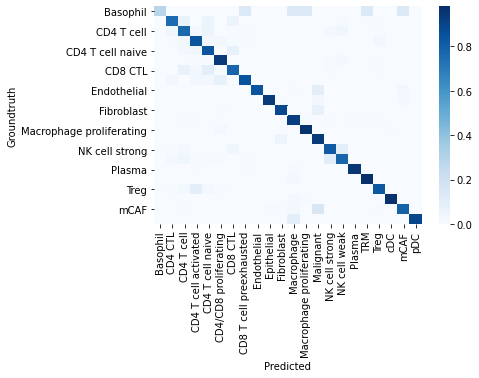

In [12]:
import matplotlib.pyplot as plt
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [13]:
preds = predict_from_anndata(adata, model)
emb = embed_from_anndata(adata, model)

adata.obs = pd.concat((adata.obs, preds), axis=1)
adata.obsm['pollock_embedding'] = emb.values
adata.obsm['pollock_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(emb.values))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-02 16:20:30,428 0 genes in training set are missing from prediction set
2020-12-02 16:20:31,063 starting batch 1 of 13
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-02 16:20:31,389 0 genes in training set are missing from prediction set
2020-12-02 16:21:08,334 starting batch 2 of 13
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-02 16:21:08,735 0 genes in training set are missing from prediction set
2020-12-02 16:21:41,937 starting batch 3 of 13
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-02 16:21:42,319 0 genes in training set are missing from prediction set
2020-12-02 16:22:15,889 starting batch 4 of 13
is_categorical is deprecated and will be removed in a future version.  Use i

In [14]:
list(set(adata.obs['cell_type']))

['CD4 T cell activated',
 'Malignant',
 'CD8 T cell preexhausted',
 'NK cell strong',
 'pDC',
 'Endothelial',
 'cDC',
 'Treg',
 'TRM',
 'mCAF',
 'NK cell weak',
 'Macrophage proliferating',
 'CD4/CD8 proliferating',
 'CD4 T cell',
 'CD4 CTL',
 'CD8 CTL',
 'Epithelial',
 'Macrophage',
 'Basophil',
 'Fibroblast',
 'CD4 T cell naive',
 'Plasma']

In [15]:
explain, rest = balancedish_training_generator(adata, cell_type_key='cell_type',
                                               n_per_cell_type=50, oversample=False,
                                        split=1.)
background, _ = balancedish_training_generator(rest, cell_type_key='cell_type', n_per_cell_type=10,
                                               oversample=False,
                                           split=1.)
explain.shape, background.shape

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


((1074, 33538), (200, 33538))

In [16]:
w = explain_predictions(explain.copy(), background.copy(), model, prediction_key='cell_type')
w

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'aliqout_barcode' as categorical
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'predicted_cell_type' as categorical
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-02 18:29:11,997 0 genes in training set are missing from prediction set
2020-12-02 18:29:12,746 starting batch 1 of 1
is_categorical is deprecated and will be removed in 

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
cell_id,,,,,,,,,,,,,,,,,,,,,
ACAGGGACACTTCTCG-1_1,0.0,0.0,0.0,0.000035,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000032,0.0,5.539487e-06,0.0,0.0,0.000000,0.0,0.0
ACGGTCGCAGGGAATC-1_1,0.0,0.0,0.0,0.000030,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000202,0.0,3.214717e-05,0.0,0.0,0.000000,0.0,0.0
ACGTAACTCCCAGGAC-1_1,0.0,0.0,0.0,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000027,0.0,1.906072e-06,0.0,0.0,0.000000,0.0,0.0
AGAAGTACAACAGATA-1_1,0.0,0.0,0.0,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000015,0.0,2.808655e-05,0.0,0.0,0.000000,0.0,0.0
AGACAGGCAACCACGC-1_1,0.0,0.0,0.0,0.000056,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000012,0.0,7.849323e-06,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GATGGAGCAAGAGGTC-1_30,0.0,0.0,0.0,0.000051,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000012,0.0,5.720735e-07,0.0,0.0,0.000000,0.0,0.0
GTCTTTATCCCTTTGG-1_30,0.0,0.0,0.0,0.000058,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000002,0.0,5.726683e-06,0.0,0.0,0.000171,0.0,0.0
TAACGACAGCTCAGAG-1_30,0.0,0.0,0.0,0.000035,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000025,0.0,1.402167e-06,0.0,0.0,0.000000,0.0,0.0


In [18]:
import anndata

In [19]:
weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
weights.var.index = w.columns
weights

AnnData object with n_obs × n_vars = 1074 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id', 'predicted_cell_type', 'cell_type_probability', 'probability_Basophil', 'probability_CD4 CTL', 'probability_CD4 T cell', 'probability_CD4 T cell activated', 'probability_CD4 T cell naive', 'probability_CD4/CD8 proliferating', 'probability_CD8 CTL', 'probability_CD8 T cell preexhausted', 'probability_Endothelial', 'probability_Epithelial', 'probability_Fibroblast', 'probability_Macrophage', 'probability_Macrophage proliferating', 'probability_Malignant', 'probab

In [20]:
feature_adata = weights.copy()

sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata, n_neighbors=5, n_pcs=50)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata, min_dist=.5)
sc.tl.leiden(feature_adata, resolution=.3)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 1074 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id', 'predicted_cell_type', 'cell_type_probability', 'probability_Basophil', 'probability_CD4 CTL', 'probability_CD4 T cell', 'probability_CD4 T cell activated', 'probability_CD4 T cell naive', 'probability_CD4/CD8 proliferating', 'probability_CD8 CTL', 'probability_CD8 T cell preexhausted', 'probability_Endothelial', 'probability_Epithelial', 'probability_Fibroblast', 'probability_Macrophage', 'probability_Macrophage proliferating', 'probability_Malignant', 'probab

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical


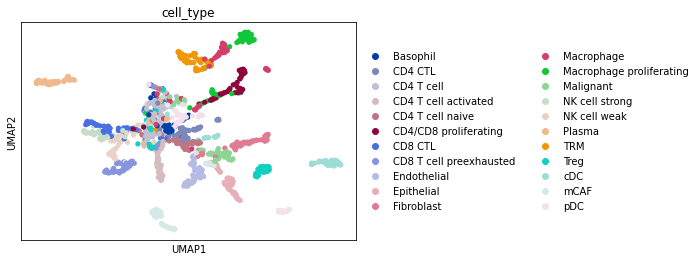

In [21]:
sc.pl.umap(feature_adata, color=['cell_type'])

In [ ]:
['GNLY',
'KLRD1',
 'KLRD1',
'CD7',]

In [220]:
marker_genes = {
#     'Basophil': ['IL3RA'],
    'T cell': ['CD3G', 'CD3D', 'CD8A'],
#     'Memory': [''],
    'Activated': ['CD69', 'CD28'],
    'Naive': ['IL7R'],
    'Effector': ['GZMA'],
    'Memory': ['CX3CR1'],
    'Regulatory': ['FOXP3'],
    'Exausted': ['PDCD1'],
    'Proliferating': ['MKI67', 'TOP2A'],
#     'nk': ['GNLY'],
#     'nk strong': ['FCGR3A', 'SPON2', 'KLRF1'],
    'NK': ['GNLY', 'CD7'],
    'NK - Strong': ['NKG7'],
    'NK - Weak': ['NCAM1'],
    'Macrophage': ['CD14', 'FCGR3A', 'LYZ'],
    'cDC': ['BATF3','IDO1'],
    'pDC': ['IL3RA'],
    'Plasma': ['SDC1'],
#     'Endothelial': ['PECAM1'],
#     'Fibroblast': ['COL1A1',
# 'SFRP2',
# 'COL3A1',
# 'COL5A1',
# 'COL12A1',
# 'EMILIN1',
# 'LUM',
# 'MMP2',
# 'TNC',
# 'S100A4'],
#     'Malignant': ['CDKN2A',
# 'CDKN2B',
# 'PTEN',
# 'PDGFRA',
# 'EGFR',
# 'ATRX',
# 'PIK3CA',
# 'TERT',
# 'MET'],
    
}

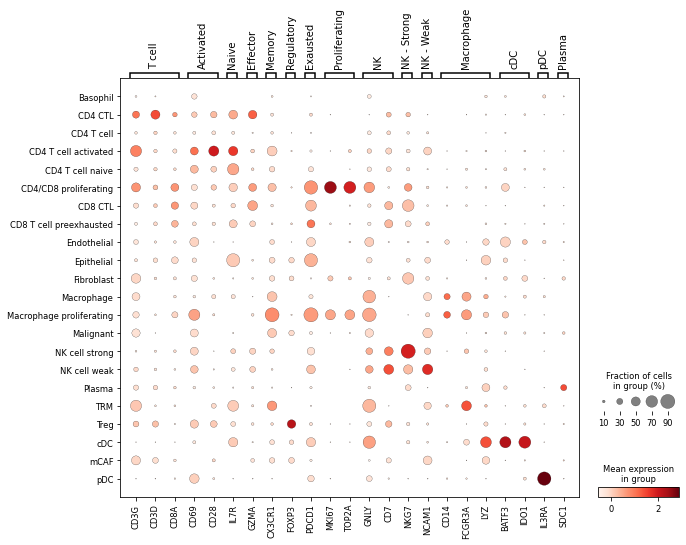

In [221]:
sc.pl.dotplot(feature_adata, var_names=marker_genes, groupby='cell_type', )

In [222]:
order = ['CD4 CTL', 'CD4 T cell activated', 'CD4 T cell naive', 'CD4/CD8 proliferating',
        'CD8 CTL', 'CD8 T cell preexhausted', 'TRM', 'Treg', 'NK cell strong', 'NK cell weak',
         'Macrophage', 'Macrophage proliferating',
         'Plasma', 'cDC', 'pDC']

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


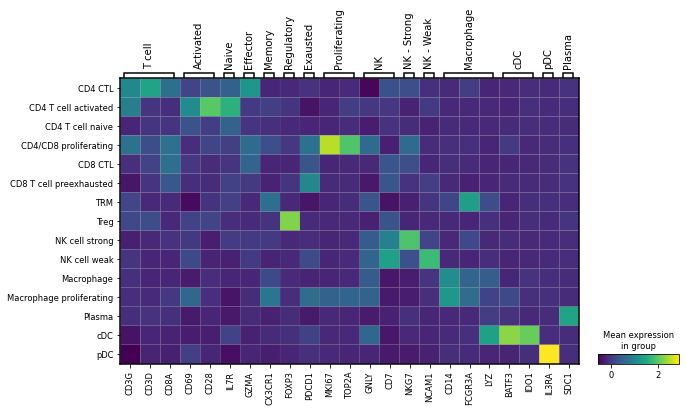

In [223]:
mini = feature_adata[[True if c in order else False for c in feature_adata.obs['cell_type']]]
sc.pl.matrixplot(mini, var_names=marker_genes, groupby='cell_type', categories_order=order)

In [225]:
feature_adata.write_h5ad(os.path.join(DATA_DIR, 'snRNAseq_ccrcc_feature_weights.h5ad'))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [226]:
adata.write_h5ad(os.path.join(DATA_DIR, 'snRNAseq_ccrcc_predictions.h5ad'))

... storing 'predicted_cell_type' as categorical


#### explain HCA immune transfer

In [ ]:
adata = 'path/to/saved/hca/processed'
module_fp = '/home/estorrs/rds_conversion/data/scRNAseq/immune/immune_module'

In [ ]:
mmy = sc.read_h5ad('/home/estorrs/data/single_cell_classification/tumor/myeloma/merged.h5ad')
mmy

In [ ]:
predictions = predict_from_anndata(mmy.copy(), module_fp)
predictions

In [ ]:
mmy.obs = pd.merge(mmy.obs, predictions, right_index=True, left_index=True)
mmy.obs

In [ ]:
embeddings = embed_from_anndata(mmy.copy(), module_fp)
embeddings

In [ ]:
mmy.obsm['X_embedding'] = embeddings.values

In [ ]:
from sklearn.preprocessing import StandardScaler
mmy.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

In [ ]:
sc.pl.embedding(mmy, basis='X_umap_embedding', color=['orig.ident', 'cell_type', 'predicted_cell_type_y',
                                                        'cell_type_probability'],
               ncols=1)

In [ ]:
sc.pl.embedding(mmy, basis='X_umap_embedding', color=['probability_Plasma Cell', 'probability_CD34+ HSC',
                                                     'probability_CD34+ LMPP', 'probability_CD34+ pre-B',
                                                     'probability_CD34+ pre-T'],
               ncols=1)

In [ ]:

# filtered = mmy[[True if c in ['Plasma', 'Plasma_BM'] else False for c in mmy.obs['cell_type']]]
filtered = mmy[[True if (c in ['Plasma Cell', 'pro-B'] or 'CD34+' in c) else False
                for c in mmy.obs['predicted_cell_type_y']]]
sc.pl.embedding(filtered, basis='X_umap_embedding', color=['cell_type', 'predicted_cell_type_y',
                                                        'cell_type_probability',
                                                          'probability_Plasma Cell'],
               ncols=1)

In [ ]:

# filtered = mmy[[True if c in ['Plasma', 'Plasma_BM'] else False for c in mmy.obs['cell_type']]]
filtered = mmy[[True if (c in ['Plasma Cell', 'pro-B'] or 'CD34+' in c) else False
                for c in mmy.obs['predicted_cell_type_y']]]
sc.pl.embedding(filtered, basis='X_umap_embedding', color=['CD34', 'HGF', 'CSF1', 'MET'],
               ncols=2)

In [ ]:
sc.pl.embedding(filtered, basis='X_umap_embedding', color=['cell_type', 'predicted_cell_type_y'],
               ncols=1, legend_loc='on data')

In [ ]:

# filtered = mmy[[True if c in ['Plasma', 'Plasma_BM'] else False for c in mmy.obs['cell_type']]]
filtered = mmy[[True if c in ['Plasma Cell', 'CD34+ pre-B', 'CD34+ pre-B cycling', 'CD34+ LMPP',
                             'CD34+ MDP-1'] else False
                for c in mmy.obs['predicted_cell_type_y']]]
sc.pl.embedding(filtered, basis='X_umap_embedding', color=['cell_type', 'predicted_cell_type_y',
                                                        'cell_type_probability',
                                                          'probability_Plasma Cell',
                                                          'probability_CD34+ pre-B',
                                                          'probability_CD34+ pre-B cycling',
                                                          'probability_CD34+ LMPP',
                                                          'probability_CD34+ MDP-1',
                                                          'probability_CD34+ HSC'],
               ncols=1)

In [ ]:
explain_filtered = filtered[filtered.obs['predicted_cell_type_y']=='Plasma Cell']
sc.pl.embedding(explain_filtered, basis='X_umap_embedding')
explain_filtered.shape

In [ ]:
explain, rest = balancedish_training_generator(explain_filtered, cell_type_key='predicted_cell_type_y',
                                               n_per_cell_type=500, oversample=False,
                                        split=1.)
background, _ = balancedish_training_generator(rest, cell_type_key='predicted_cell_type_y', n_per_cell_type=100,
                                               oversample=False,
                                           split=1.)
explain.shape, background.shape

In [ ]:
explain.obs['explain_key'] = 'CD34+ HSC'

In [ ]:
w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='explain_key')
w

In [ ]:
tumor_weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
tumor_weights.var.index = w.columns
tumor_weights

In [ ]:
feature_adata = tumor_weights.copy()

sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata, n_neighbors=5, n_pcs=40)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata, min_dist=.5)
sc.tl.leiden(feature_adata, resolution=.3)
feature_adata

#### adm portion

In [657]:
adata = sc.read_h5ad('/home/estorrs/rds_conversion/data/scRNAseq/pdac/pdac_tumor_acinar_adm.h5ad')
module_fp = '../benchmarking/sandbox/pdac_tumor_acinar_module'

In [658]:
adata

AnnData object with n_obs × n_vars = 26405 × 25368
    obs: b'orig.ident', b'nCount_RNA', b'nFeature_RNA', b'percent.mito', b'nCount_SCT', b'nFeature_SCT', b'SCT_snn_res.0.5', b'seurat_clusters', b'cell_type', b'sample', b'treatment', b'tissue', b'mutations', b'ident'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [659]:
adata.obs.columns = adata.obs.columns.astype(str)

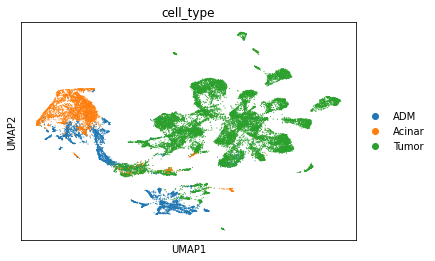

In [660]:
sc.pl.umap(adata, color='cell_type')

In [661]:
filtered = adata[adata.obs['cell_type']!='ADM'].copy()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [662]:
train, rest = balancedish_training_generator(filtered, 'cell_type', n_per_cell_type=2000, split=1.)
train

View of AnnData object with n_obs × n_vars = 4000 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [663]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=1000,
                    oversample=True, dataset_type='training', )

2020-12-03 17:55:18,013 input dataset shape: (4000, 25368)
2020-12-03 17:55:18,014 possible cell types: ['Acinar', 'Tumor']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [664]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.005, latent_dim=10, )

In [665]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:55:24,833 epoch: 1, train loss: 50.994258880615234, val loss: 62.76701354980469
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:55:29,420 epoch: 2, train loss: 50.135581970214844, val loss: 61.80577850341797
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:55:34,250 epoch: 3, train loss: 49.554283142089844, val loss: 61.171321868896484
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dty

In [666]:
pm.save(pds, module_fp)

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(33.0, 0.5, 'Groundtruth')

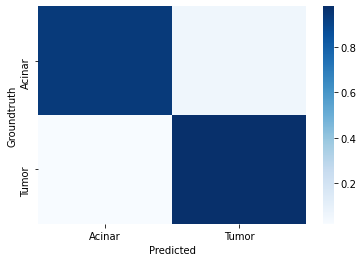

In [667]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [668]:
predictions = predict_from_anndata(adata.copy(), module_fp)
predictions

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:56:59,738 0 genes in training set are missing from prediction set
2020-12-03 17:57:00,249 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:57:00,586 0 genes in training set are missing from prediction set
2020-12-03 17:57:36,895 starting batch 2 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:57:37,405 0 genes in training set are missing from prediction set
2020-12-03 17:58:14,066 starting batch 3 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:58:14,382 0 genes in training set are missing from prediction set


,predicted_cell_type,cell_type_probability,probability_Acinar,probability_Tumor
cell_id,,,,
HT056P_S1PA_AAAGGTATCCTAGAGT-1,Tumor,0.98,0.02,0.98
HT056P_S1PA_AACACACTCGCTTTAT-1,Tumor,0.74,0.26,0.74
HT056P_S1PA_AAGCGTTGTAGATGTA-1,Tumor,0.92,0.08,0.92
HT056P_S1PA_AAGGAATGTTCCTAAG-1,Tumor,0.97,0.03,0.97
HT056P_S1PA_AAGTTCGCATGGCTAT-1,Tumor,0.98,0.02,0.98
...,...,...,...,...
HT168P1_S1H4_TTGGTTTGTAACGCGA-1,Tumor,0.99,0.01,0.99
HT168P1_S1H4_TTTACGTGTATCGCGC-1,Tumor,0.83,0.17,0.83
HT168P1_S1H4_TTTACTGCAGTAGAGC-1,Tumor,1.00,0.00,1.00


In [669]:
adata.obs = pd.merge(adata.obs, predictions, right_index=True, left_index=True)
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,cell_type,sample,treatment,tissue,mutations,ident,predicted_cell_type,cell_type_probability,probability_Acinar,probability_Tumor
HT056P_S1PA_AAAGGTATCCTAGAGT-1,TWCE-HT056P-S1PAA1-lib1,30323.0,5356,0.083402,8767.0,2760,24,24,Tumor,HT056P,FOLFIRINOX,Tumor,NA,24,Tumor,0.98,0.02,0.98
HT056P_S1PA_AACACACTCGCTTTAT-1,TWCE-HT056P-S1PAA1-lib1,3218.0,1239,0.065879,7633.0,1467,24,24,Tumor,HT056P,FOLFIRINOX,Tumor,NA,24,Tumor,0.74,0.26,0.74
HT056P_S1PA_AAGCGTTGTAGATGTA-1,TWCE-HT056P-S1PAA1-lib1,72154.0,8208,0.092704,9153.0,3262,24,24,Tumor,HT056P,FOLFIRINOX,Tumor,NA,24,Tumor,0.92,0.08,0.92
HT056P_S1PA_AAGGAATGTTCCTAAG-1,TWCE-HT056P-S1PAA1-lib1,38048.0,5498,0.064576,8880.0,2538,24,24,Tumor,HT056P,FOLFIRINOX,Tumor,NA,24,Tumor,0.97,0.03,0.97
HT056P_S1PA_AAGTTCGCATGGCTAT-1,TWCE-HT056P-S1PAA1-lib1,5177.0,2120,0.025497,7554.0,2124,24,24,Tumor,HT056P,FOLFIRINOX,Tumor,NA,24,Tumor,0.98,0.02,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H4_TTGGTTTGTAACGCGA-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,12591.0,4134,0.004845,9369.0,4116,7,7,Tumor,HT168P1,FOLFIRINOX,Tumor,NA,7,Tumor,0.99,0.01,0.99
HT168P1_S1H4_TTTACGTGTATCGCGC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,3029.0,1390,0.044569,7455.0,1632,7,7,Tumor,HT168P1,FOLFIRINOX,Tumor,NA,7,Tumor,0.83,0.17,0.83
HT168P1_S1H4_TTTACTGCAGTAGAGC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,22774.0,5032,0.044832,8741.0,3229,7,7,Tumor,HT168P1,FOLFIRINOX,Tumor,NA,7,Tumor,1.00,0.00,1.00
HT168P1_S1H4_TTTAGTCTCCCTCATG-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,9942.0,3795,0.002112,9202.0,3794,7,7,Tumor,HT168P1,FOLFIRINOX,Tumor,NA,7,Tumor,0.94,0.06,0.94


In [670]:
embeddings = embed_from_anndata(adata.copy(), module_fp)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:58:36,700 0 genes in training set are missing from prediction set
2020-12-03 17:58:37,211 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 17:58:37,551 0 genes in training set are missing from prediction set
2020-12-03 17:59:14,016 starting batch 2 of 3
2020-12-03 17:59:14,527 0 genes in training set are missing from prediction set
2020-12-03 17:59:50,798 starting batch 3 of 3
2020-12-03 17:59:51,023 0 genes in training set are missing from prediction set


,CELL_EMBEDDING_1,CELL_EMBEDDING_2,CELL_EMBEDDING_3,CELL_EMBEDDING_4,CELL_EMBEDDING_5,CELL_EMBEDDING_6,CELL_EMBEDDING_7,CELL_EMBEDDING_8,CELL_EMBEDDING_9,CELL_EMBEDDING_10
HT056P_S1PA_AAAGGTATCCTAGAGT-1,-4.722658,-4.736575,1.527269,2.444663,-2.171200,-0.198874,2.951895,-2.326452,0.998537,-1.666948
HT056P_S1PA_AACACACTCGCTTTAT-1,-3.723354,-2.276843,1.109908,-0.030177,-1.183724,0.571311,1.253973,-1.628832,0.237869,0.580526
HT056P_S1PA_AAGCGTTGTAGATGTA-1,-5.747585,-6.528355,0.549921,4.482592,-2.376636,-1.087622,3.902885,-1.963527,0.006799,1.697215
HT056P_S1PA_AAGGAATGTTCCTAAG-1,-4.763795,-3.698657,1.499440,2.313892,-1.430077,-0.274193,2.738063,-1.856622,1.093294,-1.563248
HT056P_S1PA_AAGTTCGCATGGCTAT-1,-4.235578,-3.642462,1.261388,0.614934,-0.971523,-0.124014,1.203398,-2.195369,0.061523,1.124661
...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H4_TTGGTTTGTAACGCGA-1,-0.220215,-2.993931,-0.406633,-2.604942,-1.064628,-2.105554,-0.246997,-6.785951,0.478147,-1.472147
HT168P1_S1H4_TTTACGTGTATCGCGC-1,-2.057213,-1.396685,-0.816285,-2.063267,0.039134,-0.531770,0.374519,-2.472504,0.312093,-0.203705
HT168P1_S1H4_TTTACTGCAGTAGAGC-1,-0.851333,-2.832725,1.108026,-1.886960,1.337026,-1.719671,-1.807841,-4.355203,0.240499,-2.764577
HT168P1_S1H4_TTTAGTCTCCCTCATG-1,1.506075,-5.138714,-3.109321,-2.986999,-1.410151,-4.636887,0.605606,-3.592581,0.312276,-2.085337


In [671]:
adata.obsm['X_embedding'] = embeddings.values

In [672]:
adata.obs = pd.merge(adata.obs, embeddings, left_index=True, right_index=True)

In [673]:
from sklearn.preprocessing import StandardScaler
adata.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

In [674]:
# sc.pl.embedding(adata, basis='X_embedding', color=['predicted_cell_type_y'],
# #                                                        'CELL_EMBEDDING_3', 'CELL_EMBEDDING_4',
# #                                                        'CELL_EMBEDDING_5'],
#                ncols=2, size=15)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical


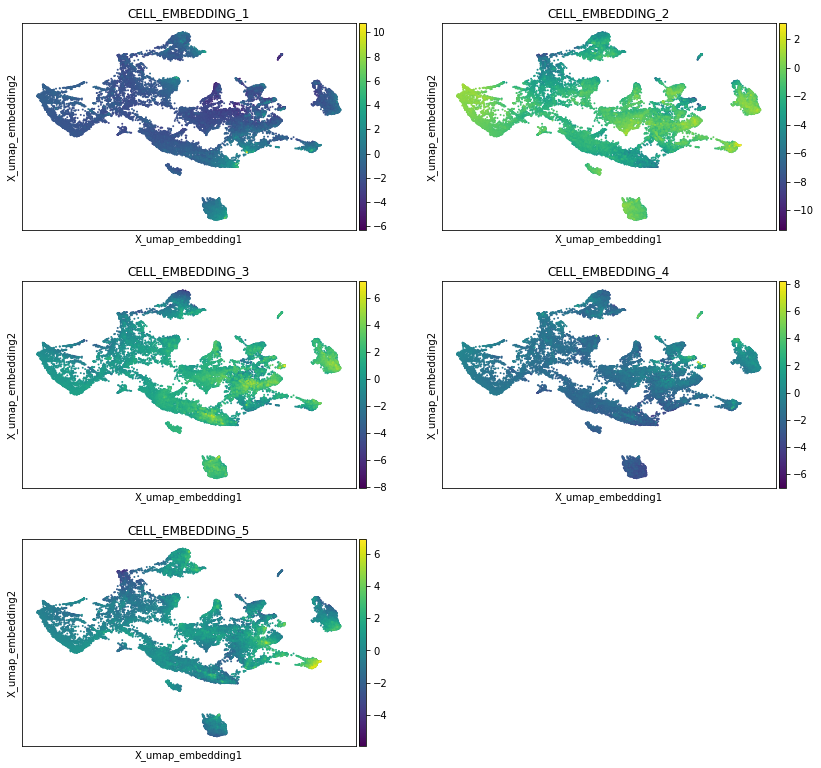

In [675]:
sc.pl.embedding(adata, basis='X_umap_embedding', color=['CELL_EMBEDDING_1', 'CELL_EMBEDDING_2',
                                                       'CELL_EMBEDDING_3', 'CELL_EMBEDDING_4',
                                                       'CELL_EMBEDDING_5'],
               ncols=2, size=15)

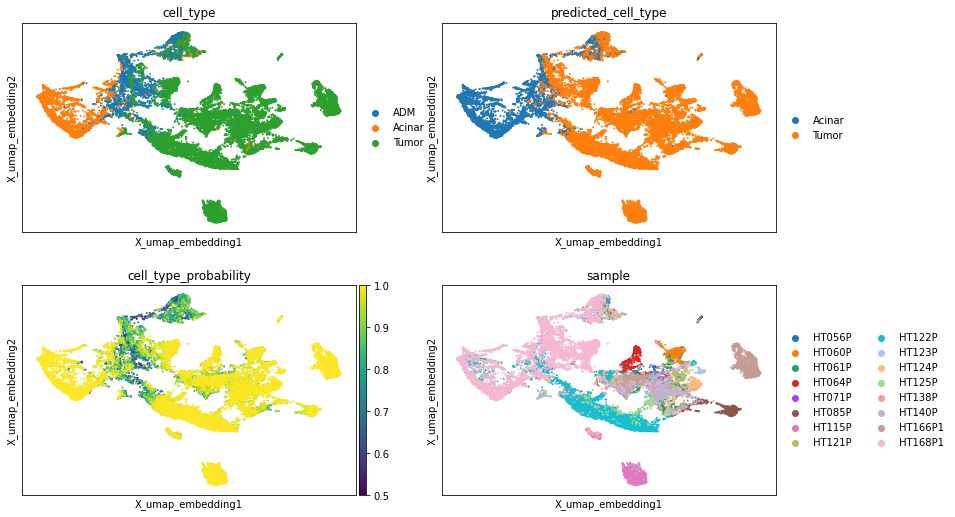

In [676]:
sc.pl.embedding(adata, basis='X_umap_embedding', color=['cell_type', 'predicted_cell_type',
                                                        'cell_type_probability', 'sample'],
               ncols=2, size=15)

In [677]:
# explain, rest = balancedish_training_generator(adata, cell_type_key='cell_type', n_per_cell_type=200, oversample=False,
#                                         split=1.)
# background, _ = balancedish_training_generator(rest, cell_type_key='cell_type', n_per_cell_type=50, oversample=False,
#                                            split=1.)
# explain

In [678]:
# explain.obs['explain_cell_types'] = 'Tumor'

In [679]:
# w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='explain_cell_types')
# w

In [680]:
# tumor_weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
# tumor_weights.var.index = w.columns
# tumor_weights

In [681]:
# feature_adata = tumor_weights.copy()

# # feature_adata.obsm['X_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(feature_adata.X))


# sc.pp.scale(feature_adata)
# sc.pp.neighbors(feature_adata)
# sc.pp.pca(feature_adata)

# sc.tl.umap(feature_adata)
# sc.tl.leiden(feature_adata, resolution=1.)
# feature_adata

In [682]:
# sc.pl.umap(feature_adata, color=['cell_type', 'predicted_cell_type',
#                                                         'cell_type_probability', 'sample'])

In [683]:
## synthetic cell

In [735]:
## create average tumor cell
# n = 10000
# ids = adata.obs.sort_values('probability_Tumor', ascending=False).index.to_list()[:n]
tumor = adata[adata.obs['probability_Tumor']>.99]
average_tumor = np.mean(tumor.X.toarray(), axis=0).flatten()
average_tumor.shape

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(25368,)

In [736]:
## create average acinar cell
acinar = adata[adata.obs['probability_Acinar']>.99]
average_acinar = np.mean(acinar.X.toarray(), axis=0).flatten()
average_acinar.shape

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(25368,)

In [737]:
average_tumor

array([0.00429711, 0.00015347, 0.00030694, ..., 0.06476366, 0.11525476,
       0.02532228], dtype=float32)

In [738]:
average_acinar

array([0.        , 0.        , 0.        , ..., 0.00276461, 0.04225908,
       0.00276461], dtype=float32)

In [739]:
## create intermediary cells
from scipy.interpolate import interp1d
n = 1000
linfit = interp1d([1,n], np.vstack([average_tumor, average_acinar]), axis=0, )
cells = np.asarray([linfit(i) for i in range(1, n+1, 1)])
cells.shape, cells

((1000, 25368),
 array([[4.29711491e-03, 1.53468383e-04, 3.06936767e-04, ...,
         6.47636577e-02, 1.15254760e-01, 2.53222827e-02],
        [4.29281349e-03, 1.53314761e-04, 3.06629523e-04, ...,
         6.47015966e-02, 1.15181691e-01, 2.52997024e-02],
        [4.28851208e-03, 1.53161139e-04, 3.06322279e-04, ...,
         6.46395355e-02, 1.15108622e-01, 2.52771222e-02],
        ...,
        [8.60283265e-06, 3.07244011e-07, 6.14488021e-07, ...,
         2.88873465e-03, 4.24052197e-02, 2.80977294e-03],
        [4.30141633e-06, 1.53622005e-07, 3.07244011e-07, ...,
         2.82667354e-03, 4.23321509e-02, 2.78719269e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.76461244e-03, 4.22590822e-02, 2.76461244e-03]]))

In [740]:
import anndata

In [741]:
synthetic_adata = anndata.AnnData(X=cells, var=adata.var)
synthetic_adata

AnnData object with n_obs × n_vars = 1000 × 25368
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'

In [742]:
embeddings = embed_from_anndata(synthetic_adata, module_fp)
transform = lambda t: t.numpy()
vfunc = np.vectorize(transform)
emb = vfunc(embeddings.values)
emb.shape

2020-12-04 11:08:24,422 0 genes in training set are missing from prediction set
2020-12-04 11:08:25,026 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-04 11:08:25,065 0 genes in training set are missing from prediction set


(1000, 10)

In [775]:
synthetic_adata.obsm['X_embedding'] = emb
synthetic_adata.obs['cell_type'] = 'synthetic'
synthetic_adata.obs['sample'] = 'synthetic'
synthetic_adata.obs['cell_type_probability'] = 1.

In [776]:
combined = anndata.concat((adata, synthetic_adata))
combined

AnnData object with n_obs × n_vars = 27405 × 25368
    obs: 'cell_type', 'sample', 'cell_type_probability'
    obsm: 'X_embedding'

In [777]:
u = umap.UMAP(min_dist=0.1)
u.fit(
    StandardScaler().fit_transform(adata.obsm['X_embedding']))
combined.obsm['X_umap_embedding'] = u.transform(StandardScaler().fit_transform(combined.obsm['X_embedding']))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type' as categorical
... storing 'sample' as categorical


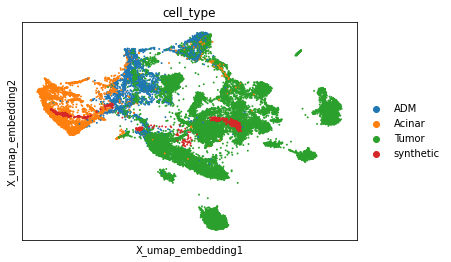

In [778]:
sc.pl.embedding(combined, basis='X_umap_embedding', color='cell_type', size=15)

In [779]:
synthetic = combined[combined.obs['cell_type']=='synthetic'].copy()
synthetic

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 1000 × 25368
    obs: 'cell_type', 'sample', 'cell_type_probability'
    uns: 'cell_type_colors'
    obsm: 'X_embedding', 'X_umap_embedding'

In [810]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
def optimal_clusters(X, cmin=2, cmax=10):
    """Determine the optimal number of clusters for the dataset"""
    scores, labels, clfs = [], [], []
    for k in range(cmin, cmax+1, 1):
#         clf = KMeans(n_clusters=k, random_state=0, ).fit(StandardScaler().fit_transform(X))
        clf = DBSCAN(eps=.5)
        clf.fit(StandardScaler().fit_transform(X))
#         print(clf.labels_)
        labels.append(clf.labels_)
        print(len(set(labels[-1])))
        scores.append(silhouette_score(X, labels[-1], ) if len(set(labels[-1]))>1 else 0.)
        clfs.append(clf)
    scores, labels = np.asarray(scores), np.asarray(labels)
    order = np.flip(np.argsort(scores))
    return [cmin + o for o in order], scores[order], labels[order], clfs
        

In [811]:
# order, scores, labels, clfs = optimal_clusters(synthetic.X.toarray(), cmin=2, cmax=10)
# order, scores

In [812]:
order, scores, labels, clfs = optimal_clusters(synthetic.obsm['X_embedding'], cmin=2, cmax=10)
order, scores

1
1
1
1
1
1
1
1
1


([10, 9, 8, 7, 6, 5, 4, 3, 2], array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [813]:
order, scores, labels, clfs = optimal_clusters(synthetic.obsm['X_umap_embedding'], cmin=2, cmax=10)
order, scores

3
3
3
3
3
3
3
3
3


([10, 9, 8, 7, 6, 5, 4, 3, 2],
 array([0.78161657, 0.78161657, 0.78161657, 0.78161657, 0.78161657,
        0.78161657, 0.78161657, 0.78161657, 0.78161657], dtype=float32))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cluster' as categorical


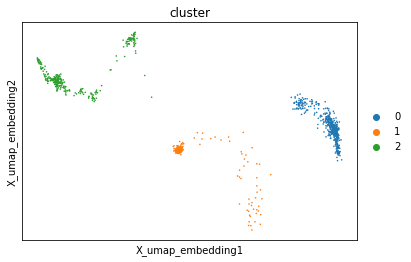

In [814]:
synthetic.obs['cluster'] = labels[0].astype(str)
sc.pl.embedding(synthetic, basis='X_umap_embedding', color='cluster', size=10)

In [815]:
def assign_clusters(sythetic, adata, cluster_key='cluster'):
    df = pd.DataFrame(data=synthetic.obsm['X_embedding'],
                 index=synthetic.obs.index.to_list())
    df['cluster'] = synthetic.obs['cluster'].to_list()
    df = df.groupby('cluster').mean()
    X = adata.obsm['X_embedding']
    distances = []
    for c in df.index:
        v = df.loc[c]
        ls = []
        for i in range(adata.shape[0]):
            ls.append(np.linalg.norm(v - X[i]))
        distances.append(ls)
    distances = np.asarray(distances)
    cluster = np.argmin(distances, axis=0)
    return cluster

In [816]:
clusters = assign_clusters(synthetic, combined)
combined.obs['cluster_assignment'] = clusters.astype(str)

... storing 'cluster_assignment' as categorical


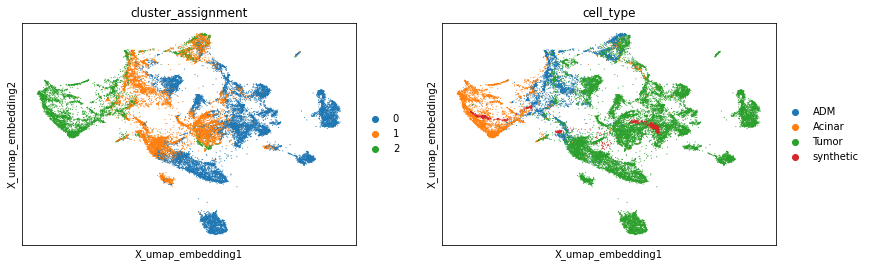

In [817]:
sc.pl.embedding(combined, basis='X_umap_embedding', color=['cluster_assignment', 'cell_type'])

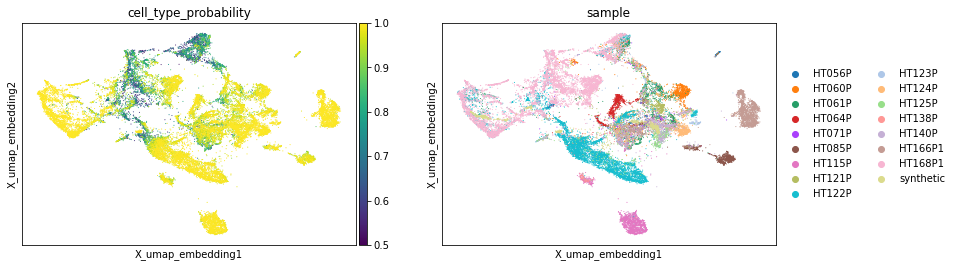

In [788]:
sc.pl.embedding(combined, basis='X_umap_embedding', color=['cell_type_probability', 'sample'])

In [818]:
explain, rest = balancedish_training_generator(combined, cell_type_key='cell_type', n_per_cell_type=200, oversample=False,
                                        split=1.)
background, _ = balancedish_training_generator(rest, cell_type_key='cell_type', n_per_cell_type=25, oversample=False,
                                           split=1.)
explain

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 800 × 25368
    obs: 'cell_type', 'sample', 'cell_type_probability', 'cluster_assignment'
    uns: 'cell_type_colors', 'sample_colors'
    obsm: 'X_embedding', 'X_umap_embedding'

In [819]:
explain.obs['explain_cell_types'] = 'Tumor'

Trying to set attribute `.obs` of view, copying.


In [820]:
w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='explain_cell_types')
w

... storing 'explain_cell_types' as categorical
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-07 10:19:23,568 0 genes in training set are missing from prediction set
2020-12-07 10:19:24,077 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-07 10:19:24,136 0 genes in training set are missing from prediction set
2020-12-07 10:19:28,853 0 genes in training set are missing from prediction set
2020-12-07 10:19:30,266 (800, 25368)


,AL627309.1,AL627309.3,AL627309.4,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.3,AL645608.1,...,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC240274.1
HT056P_S1PB_CCCTCAAGTACTCGCG-1,0.0,0.0,0.0,0.0,0.000061,0.0,0.000054,0.0,0.0,0.0,...,0.0,0.0,0.000016,0.000057,9.531289e-07,0.0,0.0,8.697293e-06,0.000068,0.000032
HT056P_S1PB_GCATCTCAGTGCTAGG-1,0.0,0.0,0.0,0.0,0.000181,0.0,0.000008,0.0,0.0,0.0,...,0.0,0.0,0.000002,0.000047,1.326361e-05,0.0,0.0,0.000000e+00,0.000013,0.000031
HT056P_S1PB_TGTAGACAGTGGTTCT-1,0.0,0.0,0.0,0.0,0.000075,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000001,3.392457e-06,0.0,0.0,0.000000e+00,0.000214,0.000012
HT056P_S1R1_ATACCGAGTATGCTAC-1,0.0,0.0,0.0,0.0,0.000053,0.0,0.000044,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000108,1.329304e-07,0.0,0.0,1.368291e-06,0.000347,0.000027
HT056P_S1R1_ATAGACCTCTAATTCC-1,0.0,0.0,0.0,0.0,0.000017,0.0,0.000025,0.0,0.0,0.0,...,0.0,0.0,0.000027,0.000060,0.000000e+00,0.0,0.0,1.052323e-06,0.000196,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,0.0,0.0,0.0,0.0,0.000032,0.0,0.000011,0.0,0.0,0.0,...,0.0,0.0,0.000023,0.000043,2.499481e-06,0.0,0.0,6.838619e-07,0.000215,0.000011
985,0.0,0.0,0.0,0.0,0.000046,0.0,0.000032,0.0,0.0,0.0,...,0.0,0.0,0.000008,0.000082,6.200970e-06,0.0,0.0,1.517658e-06,0.000213,0.000007
987,0.0,0.0,0.0,0.0,0.000081,0.0,0.000022,0.0,0.0,0.0,...,0.0,0.0,0.000015,0.000029,3.106902e-06,0.0,0.0,3.214594e-07,0.000229,0.000005
989,0.0,0.0,0.0,0.0,0.000048,0.0,0.000006,0.0,0.0,0.0,...,0.0,0.0,0.000009,0.000031,4.978829e-06,0.0,0.0,4.451566e-07,0.000177,0.000019


In [821]:
tumor_weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
tumor_weights.var.index = w.columns
tumor_weights

AnnData object with n_obs × n_vars = 800 × 25368
    obs: 'cell_type', 'sample', 'cell_type_probability', 'cluster_assignment', 'explain_cell_types'

In [822]:
feature_adata = tumor_weights.copy()

# feature_adata.obsm['X_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(feature_adata.X))


sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1.)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 800 × 25368
    obs: 'cell_type', 'sample', 'cell_type_probability', 'cluster_assignment', 'explain_cell_types', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'explain_cell_types' as categorical


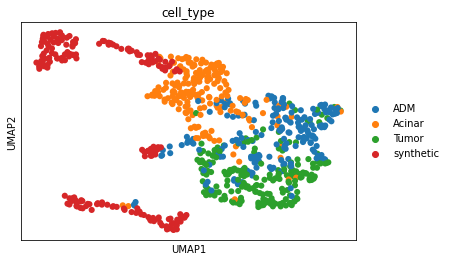

In [823]:
sc.pl.umap(feature_adata, color=['cell_type'])

In [ ]:
def optimal_clusters(X, cmin=1, cmax=10):
    """Determine the optimal number of clusters for the dataset"""
    scores, labels = [], []
    for k in range(cmin, cmax+1, 1):
        labels.append(KMeans(n_clusters=k, random_state=0).fit_transform(X))
        scores.append(sklearn.metrics.silhouette_score(X, labels[-1]))
    scores, labels = np.asarray(scores), np.asarray(labels)
    order = np.argmax(scores)
    return scores[order], labels[order]
        

In [ ]:
scores, labels = optimal_clusters(feature_adata.X, cmin=1, cmax=10)
scores, labels

#### spatial transitionary cells DCIS ICS

In [841]:
adata = sc.read_visium('/home/estorrs/data/spatial/brca_HT206/206B1_ST_Bn1_1/')
adata.var_names_make_unique()
module_fp = '../benchmarking/sandbox/brca_spatial_module'
metadata = pd.read_csv('/home/estorrs/data/spatial/brca_HT206/BRCA_206B1_seurat_annot_HandEv3_metadata.txt',
                      sep='\t')
metadata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,orig_cluster,cell_type_image,HandE_v3
AAACAAGTATCTCCCA-1,SeuratProject,1195,778,5615,1444,0,0,0,Connective_1,Others
AAACAATCTACTAGCA-1,SeuratProject,40160,7370,7616,3449,2,2,2,DCIS_connective,Tumor_IDC
AAACACCAATAACTGC-1,SeuratProject,24709,6244,7450,3396,10,10,10,Connective_5,Others
AAACAGAGCGACTCCT-1,SeuratProject,1842,1020,5852,1394,1,1,1,Connective_2,Others
AAACAGCTTTCAGAAG-1,SeuratProject,49222,9217,8601,4330,7,7,7,TDLU,Normal_TDLU
...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,SeuratProject,6233,2829,6598,2828,8,8,8,Connective_3,Others
TTGTTTCACATCCAGG-1,SeuratProject,44782,7502,7672,3442,6,6,6,IDC,Tumor_IDC
TTGTTTCATTAGTCTA-1,SeuratProject,4678,2127,6315,2127,4,4,4,Connective_4,Others
TTGTTTCCATACAACT-1,SeuratProject,1730,978,5789,1387,0,0,0,Connective_1,Others


In [842]:
idxs = adata.obs.index.to_list()
adata.obs = pd.merge(adata.obs, metadata, left_index=True, right_index=True).loc[idxs]
adata.obs

,in_tissue,array_row,array_col,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,orig_cluster,cell_type_image,HandE_v3
AAACAAGTATCTCCCA-1,1,50,102,SeuratProject,1195,778,5615,1444,0,0,0,Connective_1,Others
AAACAATCTACTAGCA-1,1,3,43,SeuratProject,40160,7370,7616,3449,2,2,2,DCIS_connective,Tumor_IDC
AAACACCAATAACTGC-1,1,59,19,SeuratProject,24709,6244,7450,3396,10,10,10,Connective_5,Others
AAACAGAGCGACTCCT-1,1,14,94,SeuratProject,1842,1020,5852,1394,1,1,1,Connective_2,Others
AAACAGCTTTCAGAAG-1,1,43,9,SeuratProject,49222,9217,8601,4330,7,7,7,TDLU,Normal_TDLU
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,SeuratProject,6233,2829,6598,2828,8,8,8,Connective_3,Others
TTGTTTCACATCCAGG-1,1,58,42,SeuratProject,44782,7502,7672,3442,6,6,6,IDC,Tumor_IDC
TTGTTTCATTAGTCTA-1,1,60,30,SeuratProject,4678,2127,6315,2127,4,4,4,Connective_4,Others
TTGTTTCCATACAACT-1,1,45,27,SeuratProject,1730,978,5789,1387,0,0,0,Connective_1,Others


In [843]:
adata

AnnData object with n_obs × n_vars = 3651 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'orig_cluster', 'cell_type_image', 'HandE_v3'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [844]:
Counter(adata.obs['HandE_v3'])

Counter({'Others': 2883,
         'Tumor_IDC': 277,
         'Normal_TDLU': 133,
         'Lymphocyte': 250,
         'Tumor': 85,
         'Tumor_DCIS': 23})

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'orig.ident' as categorical
... storing 'cell_type_image' as categorical
... storing 'HandE_v3' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


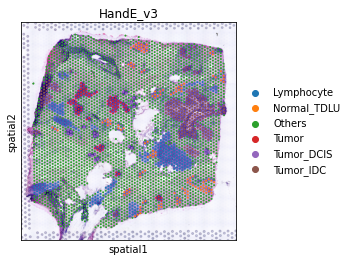

In [845]:
sc.pl.spatial(adata, color='HandE_v3')

In [846]:
filtered = adata[[True if 'DCIS' in x or 'IDC' in x else False for x in adata.obs['HandE_v3']]].copy()
filtered.obs['cell_type'] = filtered.obs['HandE_v3'].to_list()
filtered

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 300 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'orig_cluster', 'cell_type_image', 'HandE_v3', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'HandE_v3_colors'
    obsm: 'spatial'

In [847]:
Counter(filtered.obs['cell_type'])

Counter({'Tumor_IDC': 277, 'Tumor_DCIS': 23})

In [848]:
# train, rest = balancedish_training_generator(filtered, 'cell_type', n_per_cell_type=2000, split=1.)
train = filtered.copy()
train

AnnData object with n_obs × n_vars = 300 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'orig_cluster', 'cell_type_image', 'HandE_v3', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'HandE_v3_colors'
    obsm: 'spatial'

In [849]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=200,
                    oversample=True, dataset_type='training', )

2020-12-09 10:50:23,928 input dataset shape: (300, 36601)
2020-12-09 10:50:23,929 possible cell types: ['Tumor_DCIS', 'Tumor_IDC']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [850]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.005, latent_dim=10, )

In [851]:
pm.fit(pds, epochs=20)

2020-12-09 10:50:30,763 5 out of the last 733 calls to <function compute_loss at 0x7f64e675a4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-09 10:50:30,889 6 out of the last 735 calls to <function compute_loss at 0x7f64e675a4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


2020-12-09 10:50:31,010 6 out of the last 11 calls to <function compute_loss at 0x7f64e675a4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-12-09 10:50:31,125 7 out of the last 12 calls to <function compute_loss at 0x7f64e675a4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-09 10:50:31,427 epoch: 1, train loss: 465.6835021972656, val loss: 475.20184326171875
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-09 10:50:32,476 epoch: 2, train lo

In [852]:
pm.save(pds, module_fp)

Text(32.09375, 0.5, 'Groundtruth')

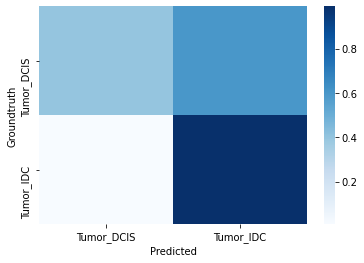

In [853]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [854]:
predictions = predict_from_anndata(adata.copy(), module_fp)
predictions

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-09 10:51:49,252 0 genes in training set are missing from prediction set
2020-12-09 10:51:50,083 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-09 10:51:50,191 0 genes in training set are missing from prediction set


,predicted_cell_type,cell_type_probability,probability_Tumor_DCIS,probability_Tumor_IDC
cell_id,,,,
AAACAAGTATCTCCCA-1,Tumor_DCIS,0.60,0.60,0.40
AAACAATCTACTAGCA-1,Tumor_IDC,0.97,0.03,0.97
AAACACCAATAACTGC-1,Tumor_IDC,0.95,0.05,0.95
AAACAGAGCGACTCCT-1,Tumor_IDC,0.52,0.48,0.52
AAACAGCTTTCAGAAG-1,Tumor_IDC,0.79,0.21,0.79
...,...,...,...,...
TTGTTGTGTGTCAAGA-1,Tumor_IDC,0.53,0.47,0.53
TTGTTTCACATCCAGG-1,Tumor_IDC,1.00,0.00,1.00
TTGTTTCATTAGTCTA-1,Tumor_DCIS,0.74,0.74,0.26


In [855]:
adata.obs = pd.merge(adata.obs, predictions, right_index=True, left_index=True)
adata.obs

,in_tissue,array_row,array_col,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,orig_cluster,cell_type_image,HandE_v3,predicted_cell_type,cell_type_probability,probability_Tumor_DCIS,probability_Tumor_IDC
AAACAAGTATCTCCCA-1,1,50,102,SeuratProject,1195,778,5615,1444,0,0,0,Connective_1,Others,Tumor_DCIS,0.60,0.60,0.40
AAACAATCTACTAGCA-1,1,3,43,SeuratProject,40160,7370,7616,3449,2,2,2,DCIS_connective,Tumor_IDC,Tumor_IDC,0.97,0.03,0.97
AAACACCAATAACTGC-1,1,59,19,SeuratProject,24709,6244,7450,3396,10,10,10,Connective_5,Others,Tumor_IDC,0.95,0.05,0.95
AAACAGAGCGACTCCT-1,1,14,94,SeuratProject,1842,1020,5852,1394,1,1,1,Connective_2,Others,Tumor_IDC,0.52,0.48,0.52
AAACAGCTTTCAGAAG-1,1,43,9,SeuratProject,49222,9217,8601,4330,7,7,7,TDLU,Normal_TDLU,Tumor_IDC,0.79,0.21,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,SeuratProject,6233,2829,6598,2828,8,8,8,Connective_3,Others,Tumor_IDC,0.53,0.47,0.53
TTGTTTCACATCCAGG-1,1,58,42,SeuratProject,44782,7502,7672,3442,6,6,6,IDC,Tumor_IDC,Tumor_IDC,1.00,0.00,1.00
TTGTTTCATTAGTCTA-1,1,60,30,SeuratProject,4678,2127,6315,2127,4,4,4,Connective_4,Others,Tumor_DCIS,0.74,0.74,0.26
TTGTTTCCATACAACT-1,1,45,27,SeuratProject,1730,978,5789,1387,0,0,0,Connective_1,Others,Tumor_DCIS,0.58,0.58,0.42


In [856]:
embeddings = embed_from_anndata(adata.copy(), module_fp)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-09 10:52:28,121 0 genes in training set are missing from prediction set
2020-12-09 10:52:28,845 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-09 10:52:28,955 0 genes in training set are missing from prediction set


,CELL_EMBEDDING_1,CELL_EMBEDDING_2,CELL_EMBEDDING_3,CELL_EMBEDDING_4,CELL_EMBEDDING_5,CELL_EMBEDDING_6,CELL_EMBEDDING_7,CELL_EMBEDDING_8,CELL_EMBEDDING_9,CELL_EMBEDDING_10
AAACAAGTATCTCCCA-1,0.053767,0.282978,0.051110,-0.036567,-0.015964,0.038819,-0.095124,-0.001193,0.038222,-0.056781
AAACAATCTACTAGCA-1,0.681665,6.743081,1.124333,-0.919882,0.069121,1.115436,-2.390655,0.616072,0.820672,-0.294034
AAACACCAATAACTGC-1,0.728170,4.609259,0.657768,-0.453483,-0.116695,0.277838,-1.512735,0.435945,0.441952,-0.150704
AAACAGAGCGACTCCT-1,0.045667,0.357157,0.047400,-0.013168,-0.000404,0.021797,-0.116572,0.062367,0.062986,-0.052261
AAACAGCTTTCAGAAG-1,1.802860,12.718328,2.292614,-0.863677,-0.895535,1.115221,-4.306972,1.611917,0.813441,-0.789294
...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.258165,1.536329,0.284153,-0.214862,-0.112925,0.126560,-0.536850,0.207546,0.118358,-0.035289
TTGTTTCACATCCAGG-1,0.913007,7.191455,1.135841,-0.948280,-0.147270,0.931622,-2.765913,1.002820,0.894022,-0.465205
TTGTTTCATTAGTCTA-1,0.087787,0.843363,0.151461,-0.105527,-0.011955,0.121557,-0.266273,0.085556,0.083711,-0.039693
TTGTTTCCATACAACT-1,0.040896,0.334724,0.066829,-0.050158,0.001057,0.043962,-0.117908,0.066640,0.041998,-0.025763


In [857]:
adata.obsm['X_embedding'] = embeddings.values

In [858]:
adata.obs = pd.merge(adata.obs, embeddings, left_index=True, right_index=True)

In [859]:
from sklearn.preprocessing import StandardScaler
adata.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

In [864]:
refiltered = adata[[True if 'Tumor' in x else False for x in adata.obs['HandE_v3']]]
refiltered

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 385 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'orig_cluster', 'cell_type_image', 'HandE_v3', 'predicted_cell_type', 'cell_type_probability', 'probability_Tumor_DCIS', 'probability_Tumor_IDC', 'CELL_EMBEDDING_1', 'CELL_EMBEDDING_2', 'CELL_EMBEDDING_3', 'CELL_EMBEDDING_4', 'CELL_EMBEDDING_5', 'CELL_EMBEDDING_6', 'CELL_EMBEDDING_7', 'CELL_EMBEDDING_8', 'CELL_EMBEDDING_9', 'CELL_EMBEDDING_10'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'HandE_v3_colors', 'predicted_cell_type_colors'
    obsm: 'spatial', 'X_embedding', 'X_umap_embedding'

In [867]:
refiltered.obsm['X_umap_embedding_re'] = umap.UMAP().fit_transform(StandardScaler(
    ).fit_transform(refiltered.obsm['X_embedding']))

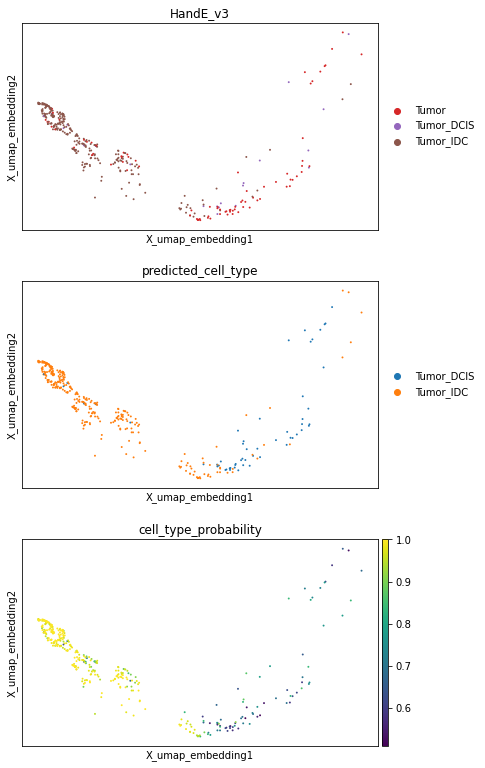

In [865]:
sc.pl.embedding(refiltered, basis='X_umap_embedding', color=['HandE_v3', 'predicted_cell_type',
                                                        'cell_type_probability'],
               ncols=1, size=15)

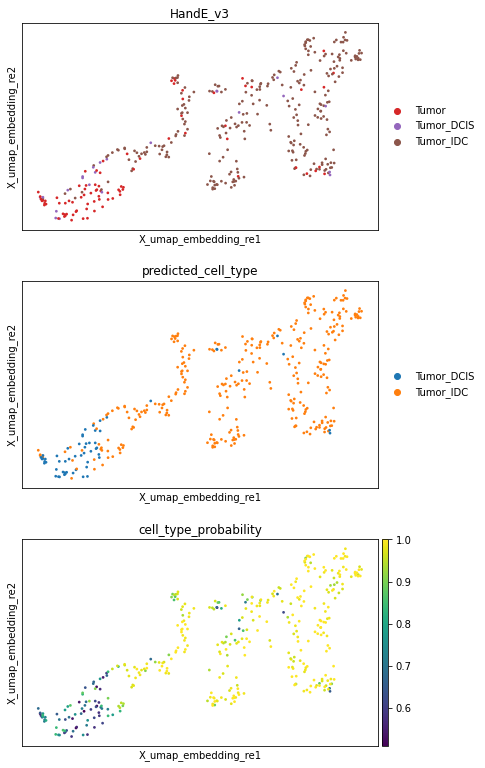

In [870]:
sc.pl.embedding(refiltered, basis='X_umap_embedding_re', color=['HandE_v3', 'predicted_cell_type',
                                                        'cell_type_probability'],
               ncols=1, size=30)

In [873]:
adata.obs['predicted'] = [refiltered.obs.loc[c, 'predicted_cell_type'] if c in refiltered.obs.index else 'Other'
                         for c in adata.obs.index]

In [878]:
adata.obs['probability'] = [x if 'Tumor' in y else 0. for x, y in zip(adata.obs['cell_type_probability'], adata.obs['HandE_v3'])]

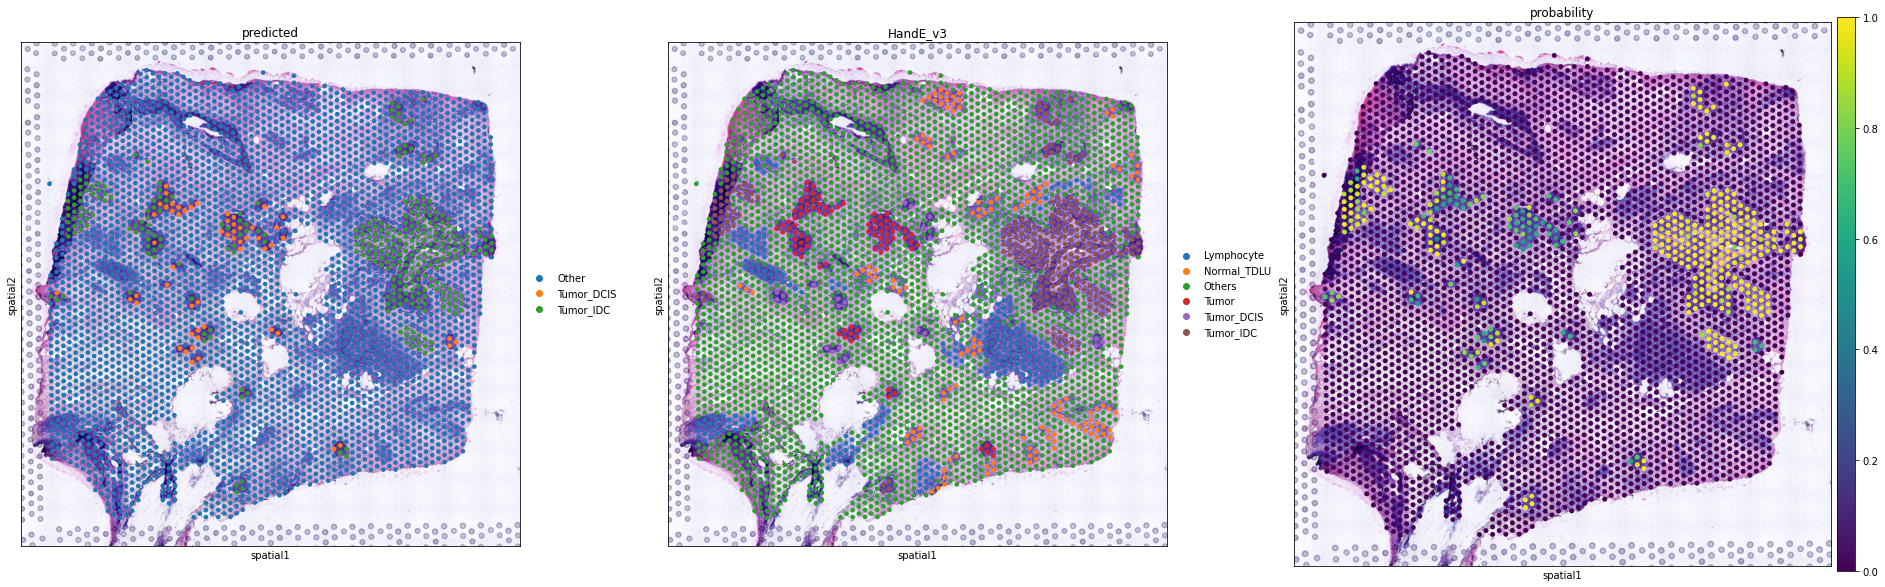

In [879]:
plt.rcParams["figure.figsize"] = (10, 10)
sc.pl.spatial(adata, color=['predicted', 'HandE_v3', 'probability'],)